In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from utils.conn_data import load_pickle
from portfolio_tools.Diagnostics import Diagnostics
from functionals.Functionals import Functionals

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [2]:
# parameters
k = 1000
train = True
strategy_name = "etfstsm_moskowitz"
diag = Diagnostics()

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = sorted(os.listdir(os.path.join(outputs_path, strategy_name)))

print(dirs)

['% Positive Ret._means_0.1_1000', '% Positive Ret._means_0.2_1000', '% Positive Ret._means_0.3_1000', '% Positive Ret._means_0.4_1000', '% Positive Ret._means_0.5_1000', '% Positive Ret._means_0.6_1000', '% Positive Ret._means_0.7_1000', '% Positive Ret._means_0.8_1000', '% Positive Ret._means_0.9_1000', '% Positive Ret._means_1.0_1000', 'AvgDD_means_0.1_1000', 'AvgDD_means_0.2_1000', 'AvgDD_means_0.3_1000', 'AvgDD_means_0.4_1000', 'AvgDD_means_0.5_1000', 'AvgDD_means_0.6_1000', 'AvgDD_means_0.7_1000', 'AvgDD_means_0.8_1000', 'AvgDD_means_0.9_1000', 'AvgDD_means_1.0_1000', 'MaxDD_means_0.1_1000', 'MaxDD_means_0.2_1000', 'MaxDD_means_0.3_1000', 'MaxDD_means_0.4_1000', 'MaxDD_means_0.5_1000', 'MaxDD_means_0.6_1000', 'MaxDD_means_0.7_1000', 'MaxDD_means_0.8_1000', 'MaxDD_means_0.9_1000', 'MaxDD_means_1.0_1000', 'Sharpe_means_0.1_1000', 'Sharpe_means_0.2_1000', 'Sharpe_means_0.3_1000', 'Sharpe_means_0.4_1000', 'Sharpe_means_0.5_1000', 'Sharpe_means_0.6_1000', 'Sharpe_means_0.7_1000', 'Sha

Utility: Sharpe, Functional: means, Alpha: 0.1, Bsize: 1000


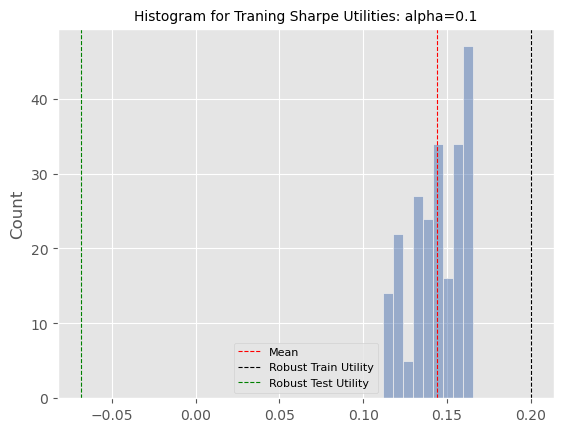

Utility: Sharpe, Functional: means, Alpha: 0.2, Bsize: 1000


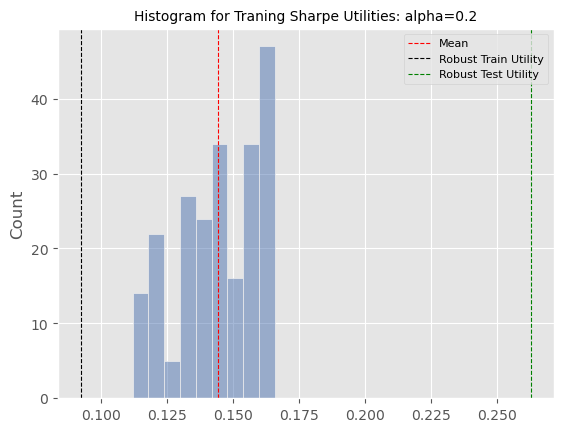

Utility: Sharpe, Functional: means, Alpha: 0.3, Bsize: 1000


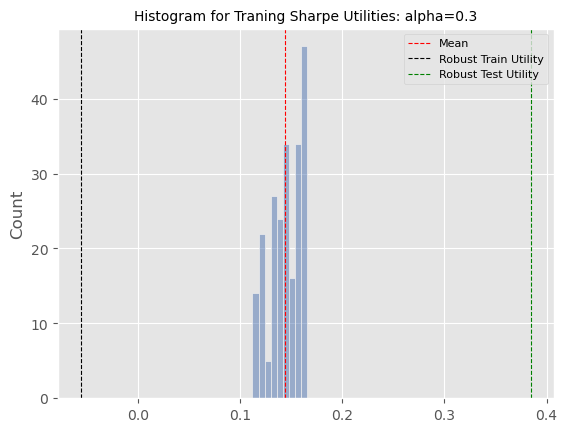

Utility: Sharpe, Functional: means, Alpha: 0.4, Bsize: 1000


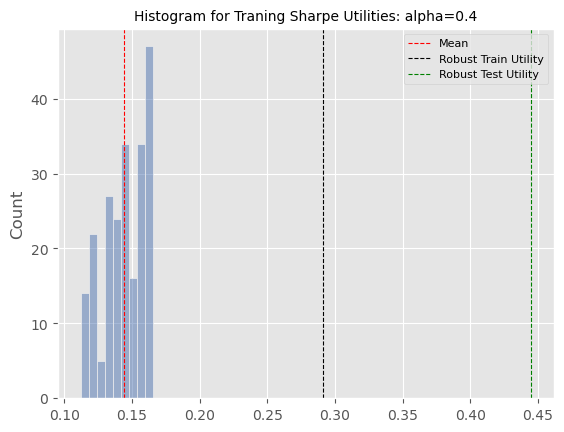

Utility: Sharpe, Functional: means, Alpha: 0.5, Bsize: 1000


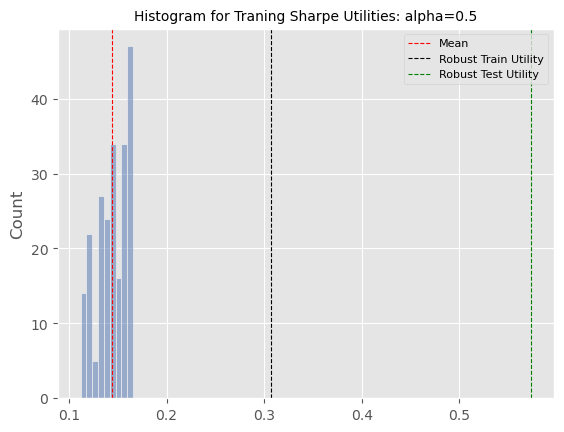

Utility: Sharpe, Functional: means, Alpha: 0.6, Bsize: 1000


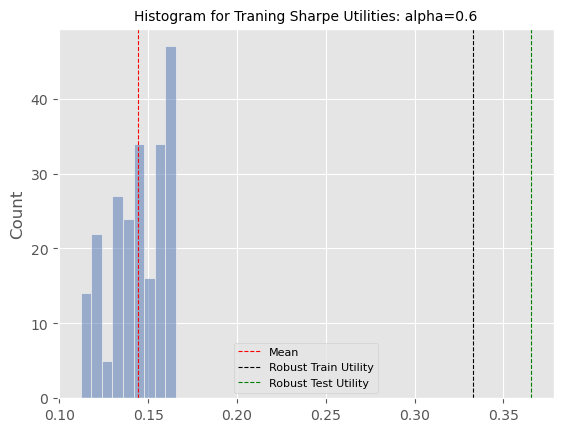

Utility: Sharpe, Functional: means, Alpha: 0.7, Bsize: 1000


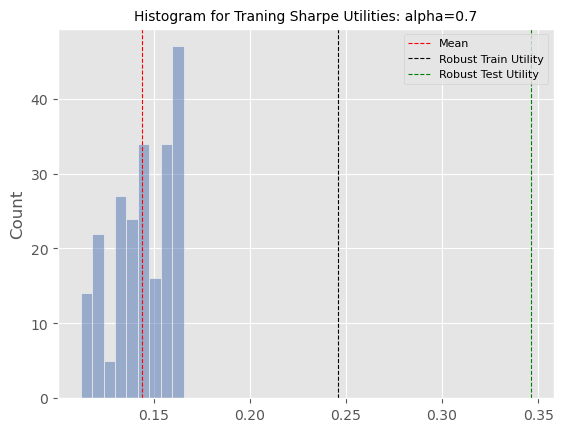

Utility: Sharpe, Functional: means, Alpha: 0.8, Bsize: 1000


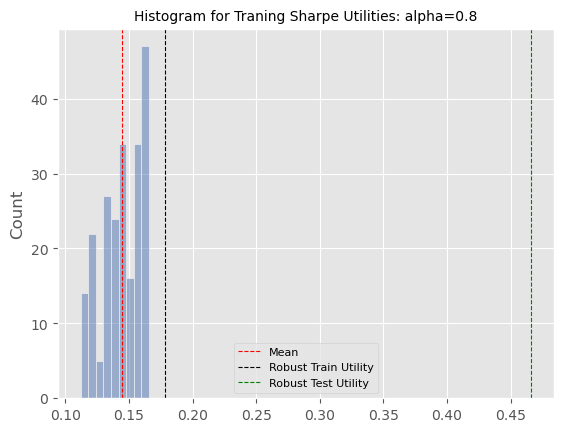

Utility: Sharpe, Functional: means, Alpha: 0.9, Bsize: 1000


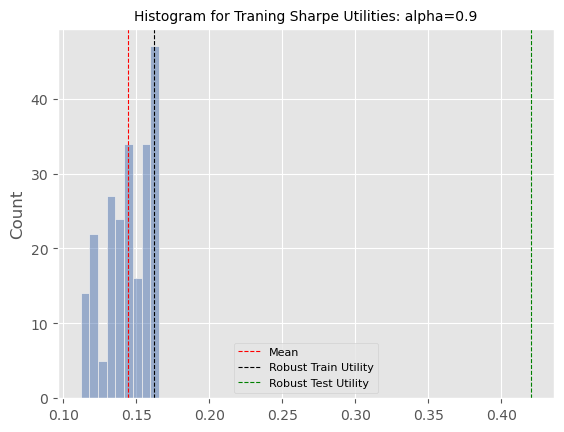

Utility: Sharpe, Functional: means, Alpha: 1.0, Bsize: 1000


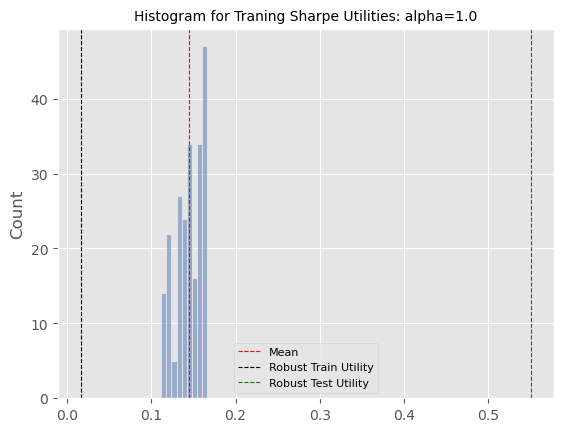

In [40]:
windows = range(30, 252 + 1, 1)

all_results = []
for dir in dirs:

    if k != int(dir.split("_")[-1]):
        continue

    utility = dir.split("_")[0]

    if utility != "Sharpe":
        continue

    functional = dir.split("_")[1]
    alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
    Bsize = dir.split("_")[3]

    functionals = Functionals(alpha=float(alpha))

    print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

    # # list files in directory
    # os.listdir(os.path.join(outputs_path, strategy_name, dir))

    optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
    portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
    portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

    # apply functional to vector of utility vectors
    utilities_val_train = functionals.means(x=optmization_train["utilities"])

    # get the chosen utility vector
    chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

    # compute robust utility
    # robust_utility_train = chosen_utility_vector_train.mean()

    # find position of scores that match final_utility
    position = functionals.find_utility_position(utilities=optmization_train["utilities"], utility_value=chosen_utility_vector_train)

    # find window that matches position
    robust_parameter = windows[position]

    # portfolio results
    robust_utility_train = diag.compute_metric(portoflio_returns=portfolio_train['agg_scaled_portfolio_returns'], metric_name=utility)
    robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

    # save results
    round_digits = 2 if utility != '% Positive Ret.' else 4
    results = {
        "Utility": utility,
        "Functional": functional,
        "Alpha": alpha,
        "Bsize": Bsize,
        "Robust Parameter": robust_parameter,
        "Train Utility Mean": np.round(utilities_val_train.mean().item(), round_digits),
        "Train Utility Std": np.round(utilities_val_train.std().item(), round_digits),
        "Robust Train Utility": np.round(robust_utility_train, round_digits),
        "Robust Test Utility": np.round(robust_utility_test, round_digits),
        "Generalization Gap": np.round(robust_utility_test - robust_utility_train, round_digits).item(),
    }

    results_df = pd.DataFrame([results])
    all_results.append(results_df)

    # plot
    utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])
    ax = sns.histplot(data=utility_val_df, palette="deep")

    plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
    plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
    plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
    plt.legend(fontsize=8)
    plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

    plt.show()
all_results_df = pd.concat(all_results)
all_results_df["Alpha"] = ["max" if val == "1.0" else val for val in all_results_df["Alpha"]]

Utility: Sharpe, Functional: means, Alpha: 1.0, Bsize: 1000


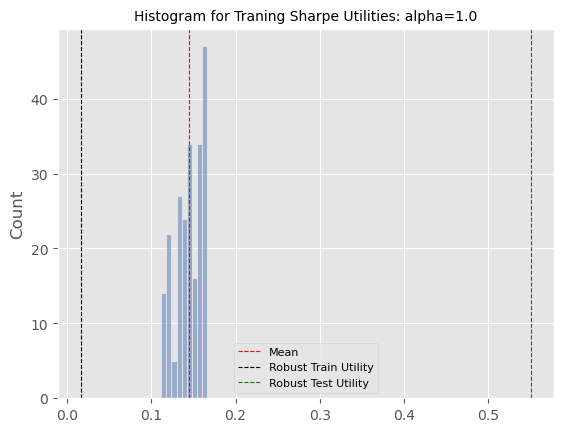

In [37]:
windows = range(30, 252 + 1, 1)

all_results = []
dir = "Sharpe_means_1.0_1000"

utility = dir.split("_")[0]

functional = dir.split("_")[1]
alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
Bsize = dir.split("_")[3]

functionals = Functionals(alpha=float(alpha))

print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

# # list files in directory
# os.listdir(os.path.join(outputs_path, strategy_name, dir))

optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

# apply functional to vector of utility vectors
utilities_val_train = functionals.means(x=optmization_train["utilities"])

# get the chosen utility vector
chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

# compute robust utility
# robust_utility_train = chosen_utility_vector_train.mean()

# find position of scores that match final_utility
position = functionals.find_utility_position(utilities=optmization_train["utilities"], utility_value=chosen_utility_vector_train)

# find window that matches position
robust_parameter = windows[position]

# portfolio results
robust_utility_train = diag.compute_metric(portoflio_returns=portfolio_train['agg_scaled_portfolio_returns'], metric_name=utility)
robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

# save results
round_digits = 2 if utility != '% Positive Ret.' else 4
results = {
    "Utility": utility,
    "Functional": functional,
    "Alpha": alpha,
    "Bsize": Bsize,
    "Robust Parameter": robust_parameter,
    "Train Utility Mean": np.round(utilities_val_train.mean().item(), round_digits),
    "Train Utility Std": np.round(utilities_val_train.std().item(), round_digits),
    "Robust Train Utility": np.round(robust_utility_train, round_digits),
    "Robust Test Utility": np.round(robust_utility_test, round_digits),
    "Generalization Gap": np.round(robust_utility_test - robust_utility_train, round_digits).item(),
}

results_df = pd.DataFrame([results])
all_results.append(results_df)

# plot
utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])
ax = sns.histplot(data=utility_val_df, palette="deep")

plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
plt.legend(fontsize=8)
plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

plt.show()

In [38]:
robust_parameter

248

<Axes: title={'center': 'Train Portfolio Returns - Sharpe = 0.02'}, xlabel='date'>

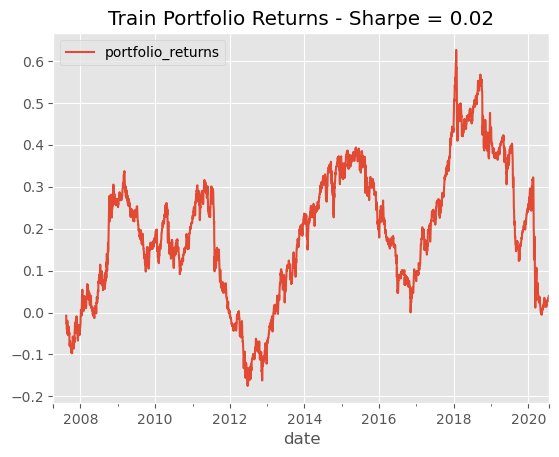

In [34]:
train_portfolio_returns = portfolio_train["agg_scaled_portfolio_returns"]

train_sharpe =  diag.compute_metric(portoflio_returns=train_portfolio_returns, metric_name=utility)
train_portfolio_returns.cumsum().plot(title=f"Train Portfolio Returns - Sharpe = {np.round(train_sharpe, 2)}")

<Axes: title={'center': 'Train Portfolio Returns - Sharpe = 0.55'}, xlabel='date'>

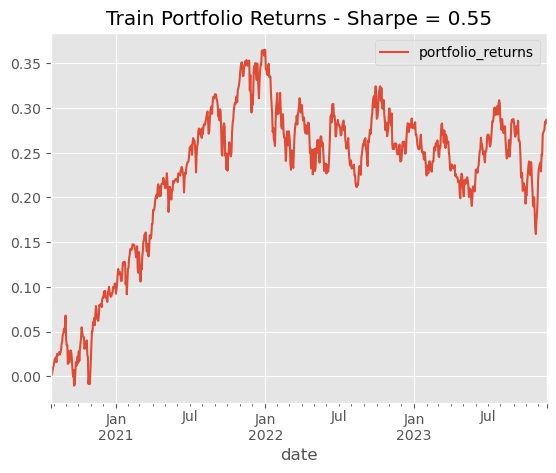

In [35]:
test_portfolio_returns = portfolio_test["agg_scaled_portfolio_returns"]

test_sharpe =  diag.compute_metric(portoflio_returns=test_portfolio_returns, metric_name=utility)
test_portfolio_returns.cumsum().plot(title=f"Train Portfolio Returns - Sharpe = {np.round(test_sharpe, 2)}")

In [41]:
all_results_df

,Utility,Functional,Alpha,Bsize,Robust Parameter,Train Utility Mean,Train Utility Std,Robust Train Utility,Robust Test Utility,Generalization Gap
0,Sharpe,means,0.1,1000,50,0.14,0.02,0.20,-0.07,-0.27
0,Sharpe,means,0.2,1000,105,0.14,0.02,0.09,0.26,0.17
0,Sharpe,means,0.3,1000,75,0.14,0.02,-0.06,0.39,0.44
0,Sharpe,means,0.4,1000,133,0.14,0.02,0.29,0.45,0.15
0,Sharpe,means,0.5,1000,137,0.14,0.02,0.31,0.57,0.27
0,Sharpe,means,0.6,1000,162,0.14,0.02,0.33,0.37,0.03
0,Sharpe,means,0.7,1000,183,0.14,0.02,0.25,0.35,0.10
0,Sharpe,means,0.8,1000,181,0.14,0.02,0.18,0.47,0.29
0,Sharpe,means,0.9,1000,241,0.14,0.02,0.16,0.42,0.26
0,Sharpe,means,max,1000,248,0.14,0.02,0.02,0.55,0.54


In [42]:
df_filtered = all_results_df.copy()
df_filtered.loc[df_filtered['Alpha'] == 'max', 'Alpha'] = 1.0
df_filtered['Alpha'] = pd.to_numeric(df_filtered['Alpha'])
df_filtered["Generalization Gap Abs"] = df_filtered["Generalization Gap"].abs()

utilities = df_filtered['Utility'].unique()

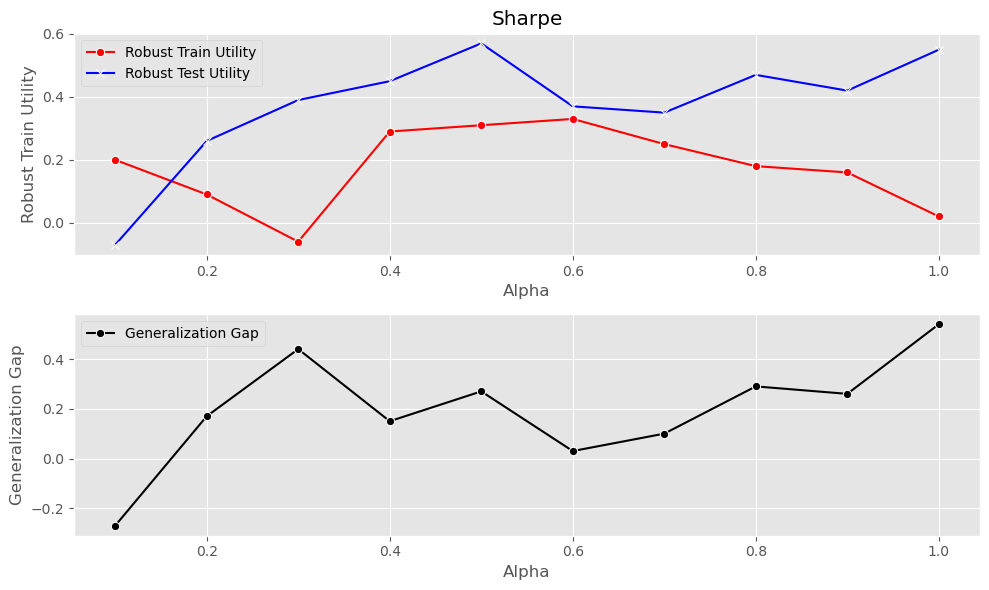

In [43]:
# Iterate over utilities and plot on a separate subplot
for i, utility in enumerate(utilities):

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
    axes = axes.flatten()   
    
    # Plot Generalization Gap Abs
    sns.lineplot(
        data=df_filtered[df_filtered['Utility'] == utility],
        x='Alpha', y='Robust Train Utility',
        ax=axes[0], marker='o', label='Robust Train Utility', color='r'
    )
    # Plot Train Utility Std on the same axis
    sns.lineplot(
        data=df_filtered[df_filtered['Utility'] == utility],
        x='Alpha', y='Robust Test Utility',
        ax=axes[0], marker='x', label='Robust Test Utility', color='b'
    )
    axes[0].set_title(f'{utility}')
    axes[0].set_xlabel('Alpha')
    axes[0].legend()  # This adds a legend to distinguish between the plots

    sns.lineplot(
        data=df_filtered[df_filtered['Utility'] == utility],
        x='Alpha', y='Generalization Gap',
        ax=axes[1], marker='o', label='Generalization Gap', color='black'
    )

    axes[1].set_xlabel('Alpha')

    # Adjust layout for better fit
    plt.tight_layout()
    plt.show()

In [ ]:
# # Setup the matplotlib figure and axes
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# axes = axes.flatten()

# # Iterate over utilities and plot on a separate subplot
# for i, utility in enumerate(utilities):
#     sns.lineplot(
#         data=df_filtered[df_filtered['Utility'] == utility],
#         x='Alpha', y='Generalization Gap Abs',
#         ax=axes[i], marker='o'
#     )

#     axes[i].set_title(f'{utility}')
#     axes[i].set_xlabel('Alpha')
#     axes[i].set_ylabel('Generalization Gap Abs')

# # Adjust layout for better fit
# plt.tight_layout()
# plt.show()